In [5]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pytesseract
import tensorflow_hub as hub

In [6]:
def parse_annotation ( xml_file ):
    if not xml_file:
            return None
    
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = root.findall('object')
    
    # find bndbox in objects
    bndbox = root.findall('object/bndbox')
    xmin = float(bndbox[0].find('xmin').text)
    ymin = float(bndbox[0].find('ymin').text)
    xmax = float(bndbox[0].find('xmax').text)
    ymax = float(bndbox[0].find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
    

In [7]:
# Function to load images and annotations
def load_data(images_folder, annotations_folder):
    images = []
    labels_list = []  # Use a list to store labels temporarily
    
    for img_file in os.listdir(images_folder):
        if img_file.endswith('.png'):
            img_path = os.path.join(images_folder, img_file)
            xml_file = os.path.join(annotations_folder, img_file.replace('.png', '.xml'))
            
            
            if os.path.exists(xml_file):
                orig_image = cv2.imread(img_path)
                image = orig_image.copy()  # Copy to draw bounding boxes on the original image
                image = cv2.resize(image, (224, 224))  # Resize the image as required
                original_size = orig_image.shape[:2]  # Original image size (height, width)
                width_ratio = 224 / original_size[1]  # Width scaling factor
                height_ratio = 224 / original_size[0]  # Height scaling factor

                boxes = parse_annotation(xml_file)
                boxes[0] = boxes[0] * width_ratio
                boxes[1] = boxes[1] * height_ratio
                boxes[2] = boxes[2] * width_ratio
                boxes[3] = boxes[3] * height_ratio
                
                images.append(image)
                labels_list.append(boxes)  # Append to labels_list
    
    return np.array(images), np.array(labels_list)
    



In [8]:
DATASET_PATH = "/kaggle/input/car-plate-detection"

images_folder = os.path.join(DATASET_PATH, "images")
annotations_folder = os.path.join(DATASET_PATH, "annotations")
print(images_folder)
print(annotations_folder)

print("Data Loading")
images, labels = load_data(images_folder, annotations_folder)
print("Data Loaded")

print(images.shape)
print(labels.shape)


# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, train_size=0.8, random_state=0)

train_images = np.array(train_images) / 255.0
val_images = np.array(val_images) / 255.0


base_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3], include_top=False,weights='imagenet')

base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),  # Adjust the number of units as needed
    tf.keras.layers.Dense(4, activation='relu')  # Adjust NUM_CLASSES for your classes
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mae'])
# Train the model
model.fit(train_images, train_labels, epochs=200, batch_size=32, validation_data=(val_images, val_labels))
model.save("mobilenetv2.keras")

/kaggle/input/car-plate-detection/images
/kaggle/input/car-plate-detection/annotations
Data Loading
Data Loaded
(433, 224, 224, 3)
(433, 4)
Epoch 1/200
11/11 [==============================] - 13s 927ms/step - loss: 15854.3232 - accuracy: 0.0173 - mae: 117.5879 - val_loss: 14986.5254 - val_accuracy: 0.1034 - val_mae: 112.8112
Epoch 2/200
11/11 [==============================] - 9s 872ms/step - loss: 11404.2119 - accuracy: 0.3815 - mae: 96.3130 - val_loss: 10047.7383 - val_accuracy: 0.4828 - val_mae: 87.9946
Epoch 3/200
11/11 [==============================] - 8s 757ms/step - loss: 6739.5967 - accuracy: 0.5607 - mae: 69.7725 - val_loss: 5594.9360 - val_accuracy: 0.4828 - val_mae: 62.3628
Epoch 4/200
11/11 [==============================] - 10s 897ms/step - loss: 3460.8245 - accuracy: 0.5607 - mae: 47.7377 - val_loss: 3196.4260 - val_accuracy: 0.4828 - val_mae: 45.6677
Epoch 5/200
11/11 [==============================] - 8s 752ms/step - loss: 2146.0278 - accuracy: 0.5607 - mae: 36.6178 -

In [12]:

def predict_bounding_boxes(model, image_path):
    # Load the image
    image = cv2.imread(image_path)
    original_image = image.copy()  # Copy to draw bounding boxes on the original image
    image = cv2.resize(image, (224, 224))  # Resize the image as required

    # Preprocess the image
    image = np.expand_dims(image, axis=0) / 255.0  # Normalize pixel values

    # Perform prediction
    predictions = model.predict(image)
    
    return predictions[0], image, original_image # Returning the predicted bounding boxes for the image and the original image


In [13]:

def draw_bounding_boxes(image, bounding_boxes, original_size):
    width_ratio = 224 / original_size[1]  # Width scaling factor
    height_ratio = 224 / original_size[0]  # Height scaling factor
    
    xmin = int(bounding_boxes[0] / width_ratio)
    ymin = int(bounding_boxes[1] / height_ratio)
    xmax = int(bounding_boxes[2] / width_ratio) 
    ymax = int(bounding_boxes[3] / height_ratio)
    
    cv2.rectangle(image, (xmin,ymin ),(xmax,ymax ),(255, 0, 255), 2)  # Draw a red rectangle around the predicted box
    
    return image

1/1 [==============================] - 0s 46ms/step
(299, 400)
(1, 224)
142 170 215 205
142 170 215 205
6
79.65752 120.78523


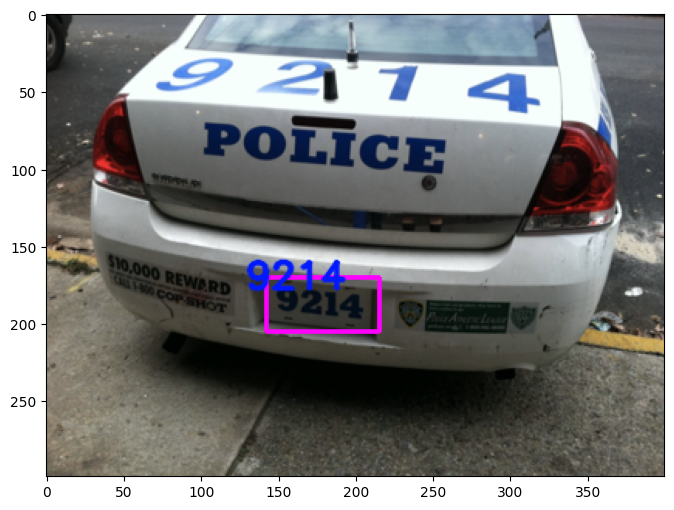

In [43]:

image_path = images_folder + '/Cars29.png'


def perform_ocr(image, bounding_box):
    width_ratio = 224 / original_size[1]  # Width scaling factor
    height_ratio = 224 / original_size[0]  # Height scaling factor
    xmin = int(bounding_box[0] / width_ratio)
    ymin = int(bounding_box[1] / height_ratio)
    xmax = int(bounding_box[2] / width_ratio) 
    ymax = int(bounding_box[3] / height_ratio)
    print(xmin, ymin,xmax,ymax)
    
    # Ensuring the bounding box coordinates are within the image dimensions
    ymin = max(0, ymin)
    ymax = min(image.shape[0], ymax)
    xmin = max(0, xmin)
    xmax = min(image.shape[1], xmax)
    print(xmin, ymin,xmax,ymax)
    
    # Extracting the region of interest (ROI) from the image
    roi = image[ymin:ymax, xmin:xmax]

    if roi.size == 0:
        return "No text detected"  # Return a message if the ROI is empty
    
    # Convert the image to RGB format (OpenCV reads images in BGR format)
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    
    # Performing OCR using pytesseract
    text = pytesseract.image_to_string(roi_rgb, config='--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    return text


#  Predicting on the new image using the loaded model
predicted_boxes, image, original_image = predict_bounding_boxes(model, image_path)

original_size = original_image.shape[:2]  # Original image size (height, width)
print(original_size)
print(image.shape[:2])
image_with_boxes = draw_bounding_boxes(original_image, predicted_boxes, original_size)

plate_text = perform_ocr(original_image, predicted_boxes)  # Performing OCR on each detected box
print(len(plate_text))
plate_text = plate_text[:-2]
print(predicted_boxes[0], predicted_boxes[2])
cv2.putText(image_with_boxes, plate_text, (int(predicted_boxes[0])+50,int(predicted_boxes[1])+50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 25, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis('on')  # Hide axis
plt.show()